# Setup: OpenCV

For this assignment you will need to use a popular and powerful library known as [OpenCV](https://opencv.org/). To do this on hub, you will need to open a terminal (File->New Launcher->Terminal) and enter `pip install opencv-python`. If you are trying to run the notebook somewhere else and can't figure out how to install the library, ask on piazza and provide details.

# Assignment: Solving Image Maze 

Given a maze as an image with a start and end point, we would like to write code to solve the maze. 

An image is a 2D matrix of pixels of a particular size that depends on its resolution. Each 
pixel has a color which is given by its Red, Green and Blue (RGB) values.
 
Given an image, we will view it as a graph where each pixel of the image is a vertex 
and edges connect a pixel to its neighbor. The weight of an edge should be very small if
the pixel colors are similar (i.e, the differences between r, g and b values are close to zero)
and correspondingly large as the pixel colors diverge.
  
Next, given a source pixel $(i_0, j_0)$ and destination pixel, 
$(i_1, j_1)$, we wish find the shortest weight path from source to destination.

You should use the Dijkstra's algorithm modified in two ways:
   - It can exit as soon as the destination is reached.
   - A 1000 x 1000 pixel image gives rise to a graph with million vertices. Storing such a graph as an adjacency list is going to be very memory intensive. Instead, your goal will be to generate the vertices and edges *on-the-fly*.
   
We will use opencv library, a popular computer vision library to load, and manipulate images of mazes.



## Manipulating Images

You can directly manipulate images in python in many ways. The `opencv` library is considered a standard for numerous
image manipulation tasks.

Here we load an image `maze.png` and you can see it nicely plotted with coordinates. We then show you two pixels
shown in red and blue. The goal here is to detect a path from one of the colored circle to the other, in the maze without crossing
the black pixels.

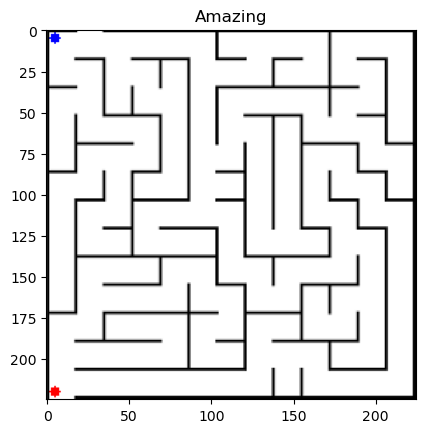

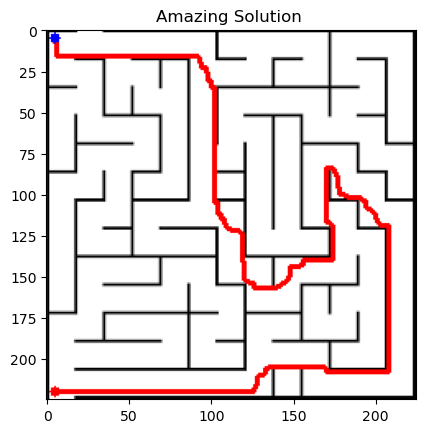

In [2]:
from matplotlib import pyplot as plt
import cv2
# You can read png, jpg and other file types 
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

img = cv2.imread('maze-solution.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing Solution ')
plt.show()


Given an image it is simple to read the color at a pixel. Let us read the color at pixel (645, 67)

In [3]:
print('Image size (height, width, num layers) is', img.shape)
px = img[145, 67] # img[y,x] is the color of the pixel of x,y
print(px)

cv2.circle(img, (80, 18), 3, (198,31,4),-1) # Draw a colored circle centered at (80, 18)
px1 = img[18, 80] # It is important to note that rows of the image are y values and columns are x values.
print(px1)

px2 = img[80, 18] # This is important to note that indexing the img data structure takes y, x values.
# Most opencv functions will require (x,y) coordinates for pixel as is natural.
print(px2)

Image size (height, width, num layers) is (225, 225, 3)
[255 255 255]
[198  31   4]
[0 0 0]


The pixel color is expressed in RGB format. R is the red value from 0 -> 255, G is the green value 0 -> 255 and B is the blue value from 0 -> 255 

We will now define a edge weight function for an edge in the image

In [4]:
import math 
def fixPixelValues(px):
    # convert the RGB values into floating point to avoid an overflow that will give me wrong answers
    return [ float(px[0]), float(px[1]), float(px[2]) ]

## Given (x,y) coordinates of two neighboring pixels, calculate the edge weight.
# We take the squared euclidean distance between the pixel values and add 0.1
def getEdgeWeight(img, u, v):
    # get edge weight for edge between u, v
    # First make sure that the edge is legit
    i0,j0 = u[0], u[1]
    i1,j1 = v[0], v[1]
    height, width, _ = img.shape
    assert i0 >= 0 and j0 >= 0 and i0 < width and j0 < height # pixel position valid?
    assert i1 >= 0 and j1 >= 0 and i1 < width and j1 < height # pixel position valid?
    assert -1 <= i0 - i1 <= 1 # edge between node and neighbor?
    assert -1 <= j0 - j1 <= 1
    px1 = fixPixelValues(img[j0,i0])
    px2 = fixPixelValues(img[j1,i1])
    return 0.1 + (px1[0] - px2[0])**2 + (px1[1] - px2[1])**2 + (px1[2]- px2[2])**2
    
# This is a useful function that given a list of (x,y) values, 
# draw a series of red lines between each coordinate and next to 
# show the path in the image
def drawPath(img, path, pThick=2):
    v = path[0]
    x0, y0 = v[0], v[1]
    for v in path:
        x, y = v[0], v[1]
        cv2.line(img,(x,y), (x0,y0), (255,0,0),pThick)
        x0, y0 = x,y
        

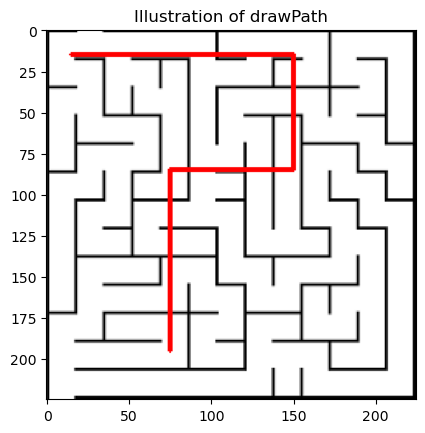

In [5]:
# Example
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
drawPath(img, [ (15, 15), (150, 15), (150, 85), (75, 85), (75, 195)])
plt.imshow(img) # show the image on the screen 
plt.title('Illustration of drawPath')
plt.show()

## Step 1: Compute Single Source Shortest Path For an Image

Given an image, compute the  shortest path between source and destination pixels by modifying Dijkstra's algorithm. __Your challenge  is to implement it without needing to create the entire the adjacency list for the graph
in the first place. However, for simplicity you can try a first cut implementation of a generic Dijkstra algorithm over
graphs represented as adjacency matrix or list.__ 

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import heapq

# Function to convert pixel values to floating point
def fixPixelValues(px):
    return [float(px[0]), float(px[1]), float(px[2])]

# Function to calculate edge weight between two neighboring pixels
def getEdgeWeight(img, u, v):
    i0, j0 = u[0], u[1]
    i1, j1 = v[0], v[1]
    height, width, _ = img.shape
    assert i0 >= 0 and j0 >= 0 and i0 < width and j0 < height  # pixel position valid?
    assert i1 >= 0 and j1 >= 0 and i1 < width and j1 < height  # pixel position valid?
    assert -1 <= i0 - i1 <= 1  # edge between node and neighbor?
    assert -1 <= j0 - j1 <= 1
    px1 = fixPixelValues(img[j0, i0])
    px2 = fixPixelValues(img[j1, i1])
    return 0.1 + (px1[0] - px2[0])**2 + (px1[1] - px2[1])**2 + (px1[2] - px2[2])**2

# Function to draw the path on the image
def drawPath(img, path, pThick=2):
    v = path[0]
    x0, y0 = v[0], v[1]
    for v in path:
        x, y = v[0], v[1]
        cv2.line(img, (x, y), (x0, y0), (255, 0, 0), pThick)
        x0, y0 = x, y

# Class to represent a vertex in the graph
class Vertex:
    def __init__(self, i, j):
        self.x = i 
        self.y = j 
        self.d = float('inf')  # the shortest path estimate
        self.processed = False  # Has this vertex's final shortest path distance been computed
        self.pi = None  # the parent vertex.

    def __lt__(self, other):
        return self.d < other.d

# Class to represent a priority queue
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def insert(self, v):
        heapq.heappush(self.elements, v)

    def get_and_delete_min(self):
        return heapq.heappop(self.elements)

    def is_empty(self):
        return len(self.elements) == 0

    def update_vertex_weight(self, v):
        # Since we can't efficiently update the position in the heap, we insert a new entry
        # with the updated distance and rely on the processed flag to ignore the old entry.
        heapq.heappush(self.elements, v)


In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import heapq

def computeShortestPath(img, source, dest):
    height, width, _ = img.shape
    dist = [[float('inf')] * width for _ in range(height)]
    dist[source[1]][source[0]] = 0
    prev = [[None] * width for _ in range(height)]
    queue = PriorityQueue()

    vertex_map = {}

    def get_vertex(i, j):
        if (i, j) not in vertex_map:
            vertex_map[(i, j)] = Vertex(i, j)
            queue.insert(vertex_map[(i, j)])
        return vertex_map[(i, j)]

    start_vertex = get_vertex(source[0], source[1])
    start_vertex.d = 0

    while not queue.is_empty():
        u = queue.get_and_delete_min()
        if u.processed:
            continue
        u.processed = True
        if (u.x, u.y) == dest:
            break
        neighbors = [(u.x + dx, u.y + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]]
        for v in neighbors:
            if 0 <= v[0] < width and 0 <= v[1] < height and not np.array_equal(img[v[1], v[0]], [0, 0, 0]):
                alt = dist[u.y][u.x] + getEdgeWeight(img, (u.x, u.y), v)
                if alt < dist[v[1]][v[0]]:
                    dist[v[1]][v[0]] = alt
                    prev[v[1]][v[0]] = (u.x, u.y)
                    vertex = get_vertex(v[0], v[1])
                    vertex.d = alt
                    queue.update_vertex_weight(vertex)

    path = []
    u = dest
    while u is not None:
        path.insert(0, u)
        u = prev[u[1]][u[0]]
    return path


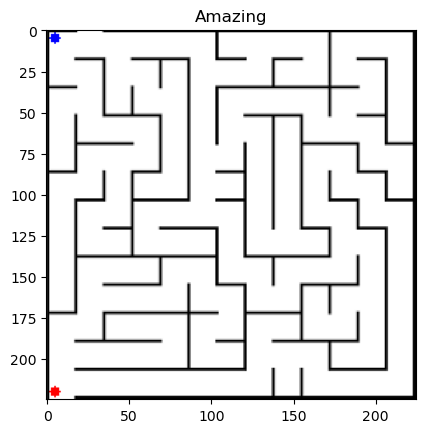

In [8]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

In [9]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (5,220), (5,5))

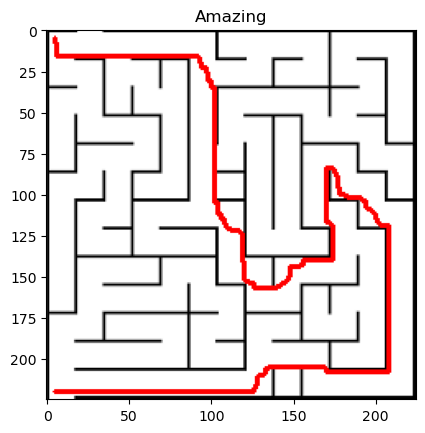

True

In [10]:
drawPath(img, p)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()
cv2.imwrite('maze-solution.png', img)

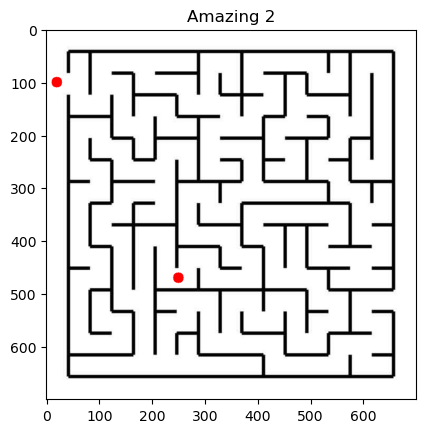

In [11]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
cv2.circle(img,(250,470), 10, (255,0,0), -1) # add a circle centered at (600, 70) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (20,100), 10, (255,0,0), -1) # add a circle centered at (790,200) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 2')
plt.show()

In [12]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (250,470), (20,100))

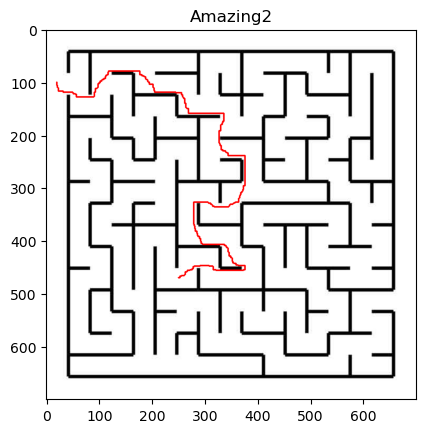

In [13]:
drawPath(img,p)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2')
plt.show()

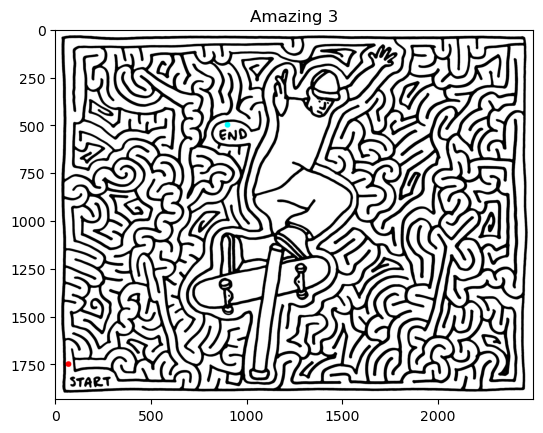

In [14]:
img = cv2.imread('maze3.JPG')
cv2.circle(img,(70,1750), 15, (255,0,0), -1) # add a circle centered at (600, 70) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (900,500), 15, (0,255,255), -1) # add a circle centered at (790,200) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 3')
plt.show()

In [15]:
img = cv2.imread('maze3.JPG') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (70,1750), (900,500))

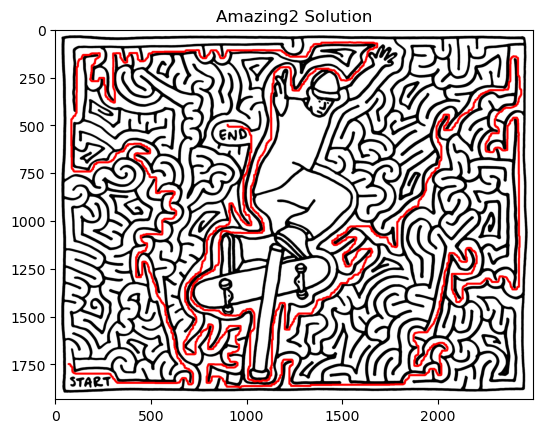

In [16]:
drawPath(img,p,10)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2 Solution')
plt.show()